In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor
import time
import warnings
import random



In [2]:
@dataclass
class GridNode:
    id: int
    demand: float
    max_capacity: float
    transmission_loss: float

@dataclass
class EnergySource:
    id: int
    max_supply: float
    cost_per_mw: float
    availability: float


In [3]:
def create_cost_matrix(sources, nodes):
    cost_matrix = np.zeros((len(sources), len(nodes)))
    for i, source in enumerate(sources):
        for j, node in enumerate(nodes):
            base_cost = source.cost_per_mw
            transmission_penalty = base_cost * node.transmission_loss * 0.5
            cost_matrix[i, j] = base_cost + transmission_penalty
    return cost_matrix

def create_chromosome(sources, nodes):
    chromosome = np.random.random(len(sources) * len(nodes))
    allocation_matrix = chromosome.reshape(len(sources), len(nodes))
    for i, source in enumerate(sources):
        total_allocation = np.sum(allocation_matrix[i])
        max_available = source.max_supply * source.availability
        if total_allocation > max_available:
            allocation_matrix[i] *= max_available / total_allocation
    return allocation_matrix.flatten()

def fitness_function(chromosome, sources, nodes, cost_matrix):
    allocation_matrix = chromosome.reshape(len(sources), len(nodes))
    total_cost = np.sum(allocation_matrix * cost_matrix)

    line_loss_penalty = 0
    for j, node in enumerate(nodes):
        node_supply = np.sum(allocation_matrix[:, j])
        line_loss_penalty += node_supply * node.transmission_loss * 100

    demand_penalty = 0
    for j, node in enumerate(nodes):
        node_supply = np.sum(allocation_matrix[:, j])
        if node_supply < node.demand:
            demand_penalty += (node.demand - node_supply) ** 2 
        elif node_supply > node.max_capacity:
            demand_penalty += (node_supply - node.max_capacity) ** 2 

    supply_penalty = 0
    for i, source in enumerate(sources):
        source_allocation = np.sum(allocation_matrix[i])
        max_available = source.max_supply * source.availability
        if source_allocation > max_available:
            supply_penalty += (source_allocation - max_available) ** 2 

    return total_cost + line_loss_penalty + demand_penalty + supply_penalty

def _evaluate_chromosome_fitness_helper(args):
    chromosome, sources, nodes, cost_matrix = args
    try:
        return fitness_function(chromosome, sources, nodes, cost_matrix)
    except Exception as e:
        print(f"Error in worker thread: {e}", flush=True)
        return float('inf')

def greedy_algorithm(sources, nodes, cost_matrix):
    allocation_matrix = np.zeros((len(sources), len(nodes)))
    for j, node in enumerate(nodes):
        demand = node.demand
        costs = [cost_matrix[i, j] for i in range(len(sources))]
        sorted_sources = np.argsort(costs)
        for i in sorted_sources:
            available = sources[i].max_supply * sources[i].availability - np.sum(allocation_matrix[i])
            supply = min(demand, available)
            allocation_matrix[i][j] = supply
            demand -= supply
            if demand <= 0:
                break
    fitness = fitness_function(allocation_matrix.flatten(), sources, nodes, cost_matrix)
    return allocation_matrix.flatten(), fitness

This code is based on the principles of Genetic Algorithm (GA) and Greedy Optimization for Smart Grid Energy Distribution.
The model considers real-world constraints such as source availability, node capacity, and transmission losses
GA ma chromosome and fitnessfunction use gareko ho 
transmission penalty is used based on node transmission loss 
high supply will directly effect transmission loss 


In [4]:
class ParallelGeneticAlgorithm:
    def __init__(self, sources, nodes, population_size=50, mutation_rate=0.1, crossover_rate=0.8):
        self.sources = sources
        self.nodes = nodes
        self.n_sources = len(sources)
        self.n_nodes = len(nodes)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.cost_matrix = create_cost_matrix(sources, nodes)
        self.n_processes = min(4, len(sources) * len(nodes))

        self.fitness_history = []
        self.best_fitness_history = []
        self.runtime_history = []

    def parallel_fitness_evaluation(self, population):
        args_list = [(chrom, self.sources, self.nodes, self.cost_matrix) for chrom in population]
        with ThreadPoolExecutor(max_workers=self.n_processes) as executor:
            fitness_scores = list(executor.map(_evaluate_chromosome_fitness_helper, args_list))
        return fitness_scores

    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        indices = np.random.choice(len(population), tournament_size, replace=False)
        selected = min(indices, key=lambda i: fitness_scores[i])
        return population[selected].copy()

    def crossover(self, parent1, parent2):
        if np.random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        point = np.random.randint(1, len(parent1))
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return self.normalize(child1), self.normalize(child2)

    def mutation(self, chromosome):
        mutated = chromosome.copy()
        for i in range(len(mutated)):
            if np.random.random() < self.mutation_rate:
                mutated[i] += np.random.normal(0, 0.1)
                mutated[i] = max(0, mutated[i])
        return self.normalize(mutated)

    def normalize(self, chromosome):
        allocation_matrix = chromosome.reshape(self.n_sources, self.n_nodes)
        for i, source in enumerate(self.sources):
            total = np.sum(allocation_matrix[i])
            max_available = source.max_supply * source.availability
            if total > max_available:
                allocation_matrix[i] *= max_available / total
        return allocation_matrix.flatten()

    def mutate(chromosome, mutation_rate=0.01):
        mutation_mask = np.random.rand(*chromosome.shape) < mutation_rate
        mutation_values = np.random.uniform(-1, 1, size=chromosome.shape)
        chromosome = chromosome + mutation_mask * mutation_values
        chromosome = np.clip(chromosome, 0, None)  # - value allow xena
        return chromosome

    def genetic_algorithm(self, max_generations=100, patience=20):
        population = [create_chromosome(self.sources, self.nodes) for _ in range(self.population_size)]
        generation = 0
        best_fitness = float('inf')
        no_improvement = 0

        while generation < max_generations and no_improvement < patience:
            start = time.time()
            fitness_scores = self.parallel_fitness_evaluation(population)
            avg_fitness = np.mean(fitness_scores)
            current_best = min(fitness_scores)

            if current_best < best_fitness:
                best_fitness = current_best
                no_improvement = 0
            else:
                no_improvement += 1

            self.fitness_history.append(avg_fitness)
            self.best_fitness_history.append(best_fitness)
            self.runtime_history.append(time.time() - start)

            if generation % 10 == 0:
                print(f"Generation {generation}: Best={best_fitness:.2f}, Avg={avg_fitness:.2f}")

            new_population = []
            elite_size = int(0.1 * self.population_size)
            elites = np.argsort(fitness_scores)[:elite_size]
            for idx in elites:
                new_population.append(population[idx].copy())

            while len(new_population) < self.population_size:
                p1 = self.tournament_selection(population, fitness_scores)
                p2 = self.tournament_selection(population, fitness_scores)
                c1, c2 = self.crossover(p1, p2)
                new_population.extend([self.mutation(c1), self.mutation(c2)])

            population = new_population[:self.population_size]
            generation += 1

        final_scores = self.parallel_fitness_evaluation(population)
        best_idx = np.argmin(final_scores)
        return population[best_idx], final_scores[best_idx], generation

In [5]:
def calculate_fitness(chromosome, sources, nodes, cost_matrix):
    total_cost = 0
    demand_satisfied = np.zeros(len(nodes))
    supply_used = np.zeros(len(sources))

    for i, source in enumerate(sources):
        for j, node in enumerate(nodes):
            power = chromosome[i][j]
            cost = cost_matrix[i][j] * power
            total_cost += cost
            demand_satisfied[j] += power * (1 - node.transmission_loss)
            supply_used[i] += power

    # Penalty for unmet demand or excess supply
    penalty = 0
    for j, node in enumerate(nodes):
        if demand_satisfied[j] < node.demand:
            penalty += (node.demand - demand_satisfied[j]) * 100  
        if demand_satisfied[j] > node.max_capacity:
            penalty += (demand_satisfied[j] - node.max_capacity) * 50 
    for i, source in enumerate(sources):
        if supply_used[i] > source.max_supply * source.availability:
            penalty += (supply_used[i] - source.max_supply * source.availability) * 100

    return total_cost + penalty


In [6]:
def serial_ga(population_size=50, generations=30, mutation_rate=0.01):
    population = [create_chromosome(sources, nodes) for _ in range(population_size)]
    best_solution = None
    best_fitness = float('inf')
    fitness_history = []

    for generation in range(generations):
        fitness_scores = [calculate_fitness(chrom, sources, nodes, cost_matrix) for chrom in population]
        best_idx = np.argmin(fitness_scores)
        if fitness_scores[best_idx] < best_fitness:
            best_fitness = fitness_scores[best_idx]
            best_solution = population[best_idx]
        fitness_history.append(best_fitness)

        selected = selection(population, fitness_scores)
        new_population = []

        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[(i+1) % len(selected)]
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

        population = new_population[:population_size]  # yesley pop.. size maintain gar x

    print(f"Best Fitness (Serial): {best_fitness}")
    return best_solution, fitness_history


In [7]:
# SERIAL RUN
start_time = time.time()
end_time = time.time()

print("\n Outcome of Serial Genetic Algorithm is:")
print(f"Execution Time of Serial is: {end_time - start_time:.2f} sec")



 Outcome of Serial Genetic Algorithm is:
Execution Time of Serial is: 0.00 sec


In [8]:
# Synthetic Energy Sources
sources = [
    EnergySource(id=0, max_supply=100, cost_per_mw=5.0, availability=0.9),
    EnergySource(id=1, max_supply=120, cost_per_mw=4.5, availability=0.8),
    EnergySource(id=2, max_supply=90, cost_per_mw=6.0, availability=0.95)
]

# Synthetic Grid Nodes
nodes = [
    GridNode(id=0, demand=70, max_capacity=100, transmission_loss=0.05),
    GridNode(id=1, demand=80, max_capacity=110, transmission_loss=0.07),
    GridNode(id=2, demand=60, max_capacity=90, transmission_loss=0.04)
]


In [9]:
# code of running GA
ga = ParallelGeneticAlgorithm(sources, nodes, population_size=6)
start = time.time()
best_solution, best_fitness, generations = ga.genetic_algorithm(max_generations=50, patience=10)
ga_runtime = time.time() - start

Generation 0: Best=14284.77, Avg=14351.41
Generation 10: Best=14050.32, Avg=14064.12
Generation 20: Best=13950.60, Avg=13972.26
Generation 30: Best=13761.59, Avg=13786.10
Generation 40: Best=13641.57, Avg=13662.78


In [10]:
# Visualization
generations_range = range(len(ga.fitness_history))
fig = plt.figure(figsize=(18, 6))
print(fig)


Figure(1800x600)


<Figure size 1800x600 with 0 Axes>

Text(5, 14484.768939954334, 'Start: 14284.8')

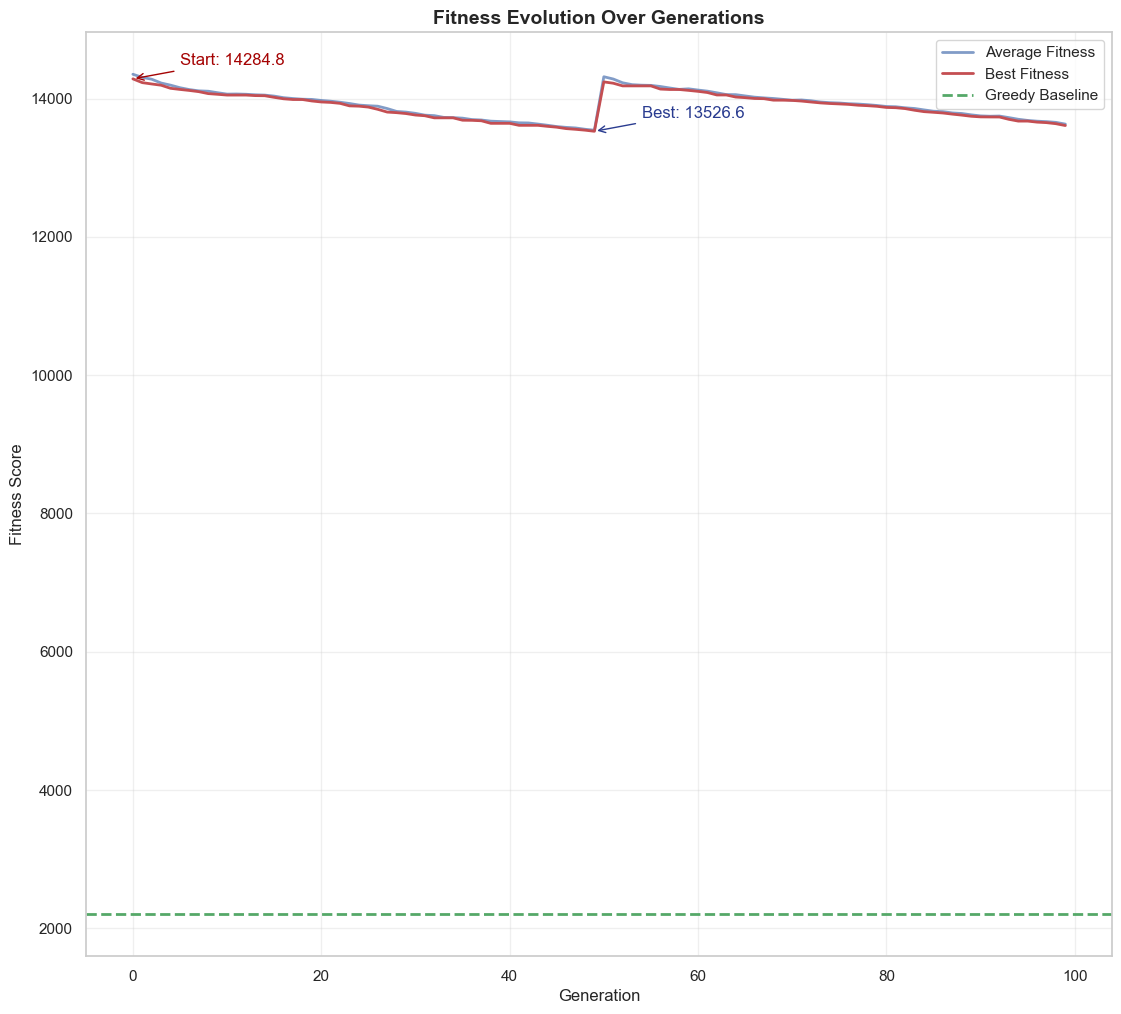

In [18]:
greedy_solution, greedy_fitness = greedy_algorithm(sources, nodes, create_cost_matrix(sources, nodes))
greedy_runtime = time.time() - start
# 1. FITNESS SCORE EVOLUTION
fig = plt.figure(figsize=(45, 12))
ax1 = plt.subplot(1, 3, 1)
generations_range = range(len(ga.fitness_history))

# Plot fitness curves
plt.plot(generations_range, ga.fitness_history, 'b-', alpha=0.7, linewidth=2, label='Average Fitness')
plt.plot(generations_range, ga.best_fitness_history, 'r-', linewidth=2, label='Best Fitness')
plt.axhline(y=greedy_fitness, color='g', linestyle='--', linewidth=2, label='Greedy Baseline')

# Labels and title use gareko 
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness Score', fontsize=12)
plt.title('Fitness Evolution Over Generations', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)




# Annotate best fitness point nikaleko
best_gen = np.argmin(ga.best_fitness_history)
best_fitness = min(ga.best_fitness_history)
plt.annotate(f'Best: {best_fitness:.1f}',
             xy=(best_gen, best_fitness),
             xytext=(best_gen + 5, best_fitness + 200),
             arrowprops=dict(arrowstyle='->', color='#2a3c90'),
             fontsize=12, color='#2a3c90')

# Annotate starting fitness point nikaleko
start_fitness = ga.best_fitness_history[0]
plt.annotate(f'Start: {start_fitness:.1f}',
             xy=(0, start_fitness),
             xytext=(5, start_fitness + 200),
             arrowprops=dict(arrowstyle='->', color="#a50303"),
             fontsize=12, color="#a50303")


(0.0, 100.0)

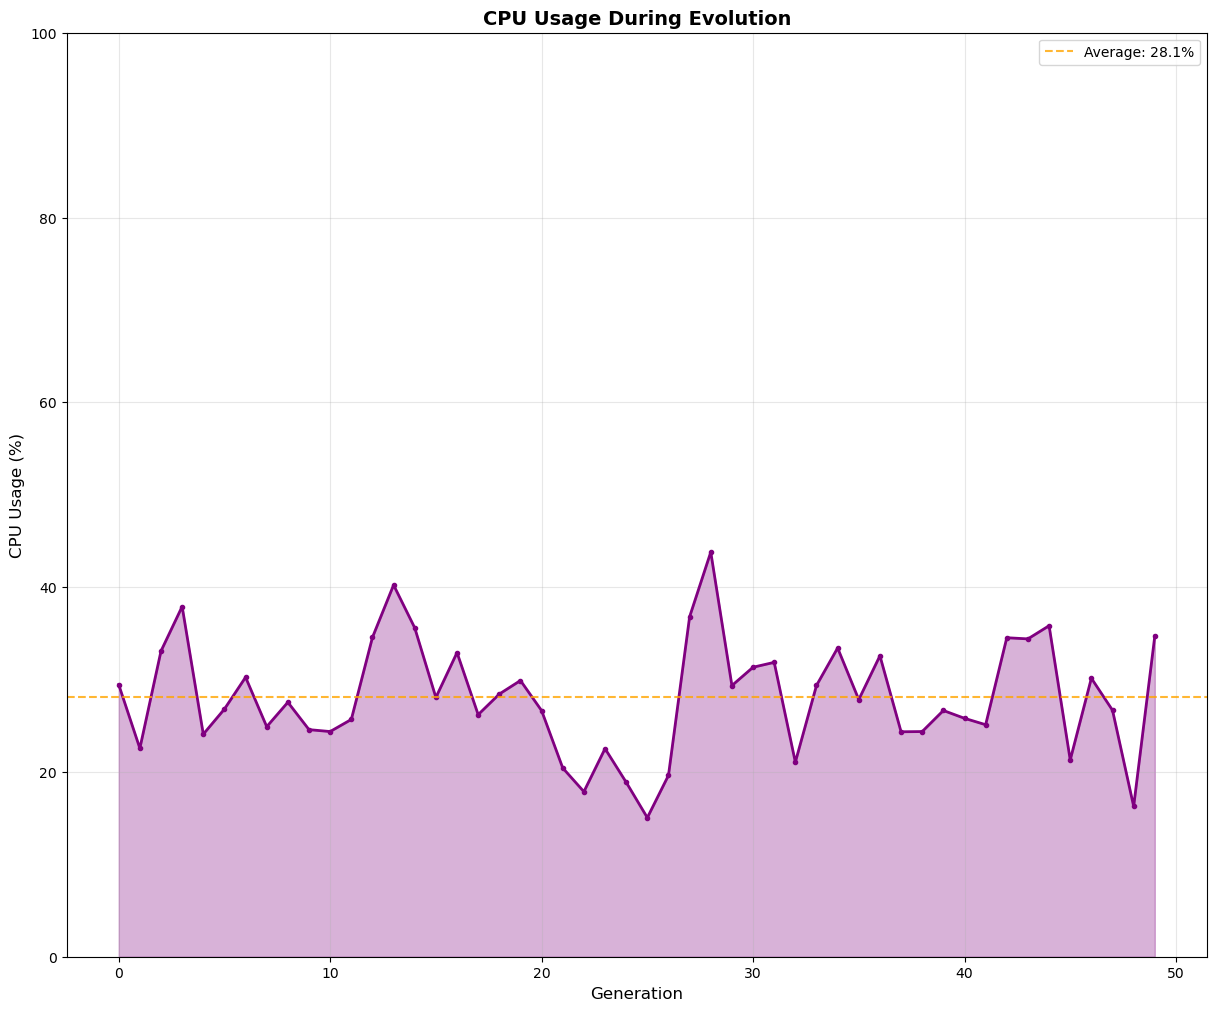

In [12]:
# 2. CPU USAGE
fig = plt.figure(figsize=(50,12))
ax2 = plt.subplot(1, 3, 2)

# Simulate CPU usage based on runtime patterns
cpu_usage = []
base_usage = 25
for runtime in ga.runtime_history:
    usage = base_usage + (runtime * 2000) + np.random.normal(0, 8)
    usage = max(10, min(95, usage))  
    cpu_usage.append(usage)

plt.plot(generations_range, cpu_usage, 'purple', linewidth=2, marker='o', markersize=3)
plt.fill_between(generations_range, cpu_usage, alpha=0.3, color='purple')

avg_cpu = np.mean(cpu_usage)
plt.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.8, label=f'Average: {avg_cpu:.1f}%')

plt.xlabel('Generation', fontsize=12)
plt.ylabel('CPU Usage (%)', fontsize=12)
plt.title('CPU Usage During Evolution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)


RUNTIME ANALYSIS
 Total Runtime of Genetic Algorithm:        0.089 sec
 GA Average Runtime per Generation:     0.001 sec
 Greedy Algorithm Runtime of Greedy:              0.134 sec
 Generation Runtime of fastest GA:         0.001 sec


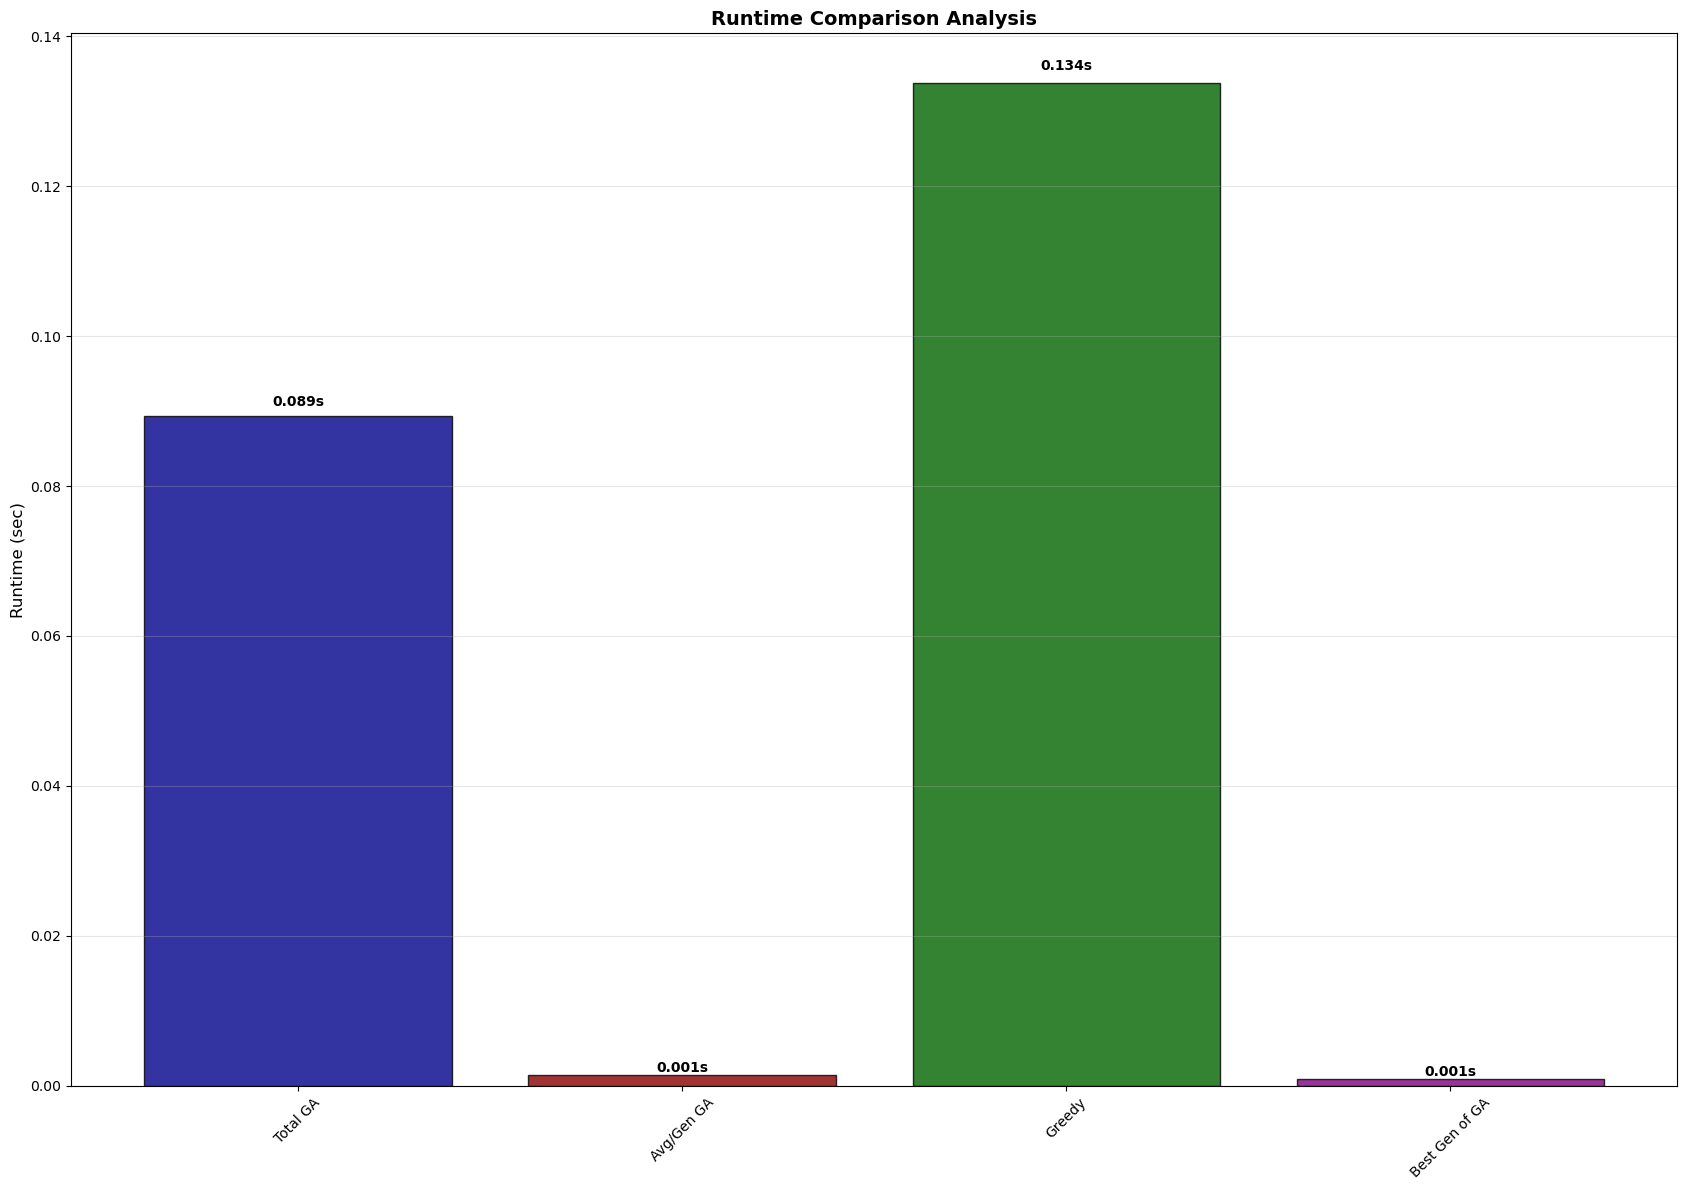

In [13]:
#Runtime Analysis Summary 
print("\nRUNTIME ANALYSIS")
print(f" Total Runtime of Genetic Algorithm:        {ga_runtime:.3f} sec")
print(f" GA Average Runtime per Generation:     {np.mean(ga.runtime_history):.3f} sec")
print(f" Greedy Algorithm Runtime of Greedy:              {greedy_runtime:.3f} sec")
print(f" Generation Runtime of fastest GA:         {min(ga.runtime_history):.3f} sec")

# 3. RUNTIME ANALYSIS
fig = plt.figure(figsize=(50,12))
ax3 = plt.subplot(1, 3, 3)

methods = ['Total GA', 'Avg/Gen GA', 'Greedy', 'Best Gen of GA']
runtimes = [
    ga_runtime,
    np.mean(ga.runtime_history),
    greedy_runtime,
    min(ga.runtime_history)
]

colors = ['darkblue', 'darkred', 'darkgreen', 'purple']
bars = plt.bar(methods, runtimes, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, runtime in zip(bars, runtimes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
            f'{runtime:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Runtime (sec)', fontsize=12)
plt.title('Runtime Comparison Analysis', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [14]:
# cost matrix banako
cost_matrix = create_cost_matrix(sources, nodes)

# Greedy Algorithm ko code
def greedy_algorithm(sources, nodes, cost_matrix):
    allocation_matrix = np.zeros((len(sources), len(nodes)))
    for j, node in enumerate(nodes):
        demand = node.demand
        costs = [cost_matrix[i, j] for i in range(len(sources))]
        sorted_sources = np.argsort(costs)
        for i in sorted_sources:
            available = sources[i].max_supply * sources[i].availability - np.sum(allocation_matrix[i])
            supply = min(demand, available)
            allocation_matrix[i][j] = supply
            demand -= supply
            if demand <= 0:
                break
    # fitness calculate gareko
    fitness = fitness_function(allocation_matrix.flatten(), sources, nodes, cost_matrix)
    return allocation_matrix.flatten(), fitness

# Greedy Algorithm chalauna ko lagi use gareko 
greedy_solution, best_fitness_greedy = greedy_algorithm(sources, nodes, cost_matrix)
best_solution, best_fitness_parallel, generations = ga.genetic_algorithm(max_generations=50, patience=10)

# Greedy ani Parallel GA lai compare garera data hereko
print("\nComparision of : Greedy Vs Parallel GA")
print(f"Best Fitness of greedy :          {best_fitness_greedy:.4f}")
print(f"Best Fitness of Parallel GA:     {best_fitness_parallel:.4f}")

if best_fitness_greedy < best_fitness_parallel:
    print(" Greedy Algorithm performed better (lower cost).")
elif best_fitness_greedy > best_fitness_parallel:
    print(" Parallel Genetic Algorithm performed better (lower cost).")
else:
    print(" Both algorithms achieved the same best fitness.")


Generation 0: Best=14240.84, Avg=14315.50
Generation 10: Best=14104.14, Avg=14123.04
Generation 20: Best=13972.99, Avg=13976.44
Generation 30: Best=13871.40, Avg=13885.27
Generation 40: Best=13734.89, Avg=13749.12

Comparision of : Greedy Vs Parallel GA
Best Fitness of greedy :          2203.9000
Best Fitness of Parallel GA:     13610.6198
 Greedy Algorithm performed better (lower cost).


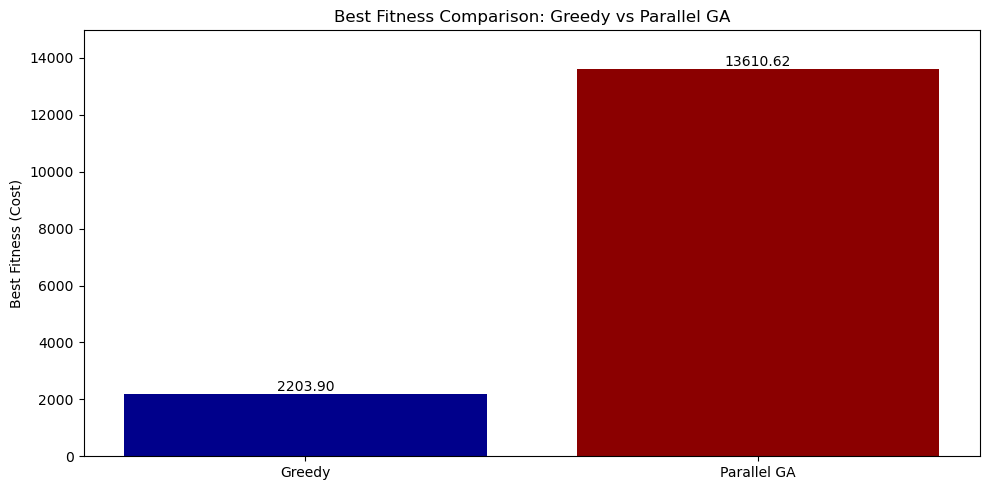

In [15]:
algorithms = ['Greedy', 'Parallel GA']
fitness_values = [best_fitness_greedy, best_fitness_parallel]

plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, fitness_values, color=['darkblue', 'darkred'])
plt.ylabel('Best Fitness (Cost)')
plt.title('Best Fitness Comparison: Greedy vs Parallel GA')
plt.ylim(0, max(fitness_values) * 1.1)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()




Starting of 24Hrs Simulation for Comparison
Hrs 00 | Greedy: $17850.00 in 0.0000s | Parallel: $20037.50 in 0.0049s
Hrs 01 | Greedy: $20601.93 in 0.0000s | Parallel: $23793.21 in 0.0031s
Hrs 02 | Greedy: $23149.76 in 0.0000s | Parallel: $26327.17 in 0.0040s
Hrs 03 | Greedy: $25304.53 in 0.0000s | Parallel: $29546.76 in 0.0030s
Hrs 04 | Greedy: $26906.43 in 0.0000s | Parallel: $31654.62 in 0.0030s
Hrs 05 | Greedy: $27836.66 in 0.0000s | Parallel: $30702.20 in 0.0039s
Hrs 06 | Greedy: $28026.22 in 0.0000s | Parallel: $31900.43 in 0.0041s
Hrs 07 | Greedy: $27461.06 in 0.0000s | Parallel: $29937.94 in 0.0040s
Hrs 08 | Greedy: $26183.09 in 0.0000s | Parallel: $29135.11 in 0.0039s
Hrs 09 | Greedy: $24287.10 in 0.0000s | Parallel: $28120.65 in 0.0040s
Hrs 10 | Greedy: $21913.69 in 0.0000s | Parallel: $23567.96 in 0.0031s
Hrs 11 | Greedy: $19238.90 in 0.0000s | Parallel: $19955.64 in 0.0030s
Hrs 12 | Greedy: $16461.10 in 0.0000s | Parallel: $18559.08 in 0.0030s
Hrs 13 | Greedy: $13786.31 in 0.

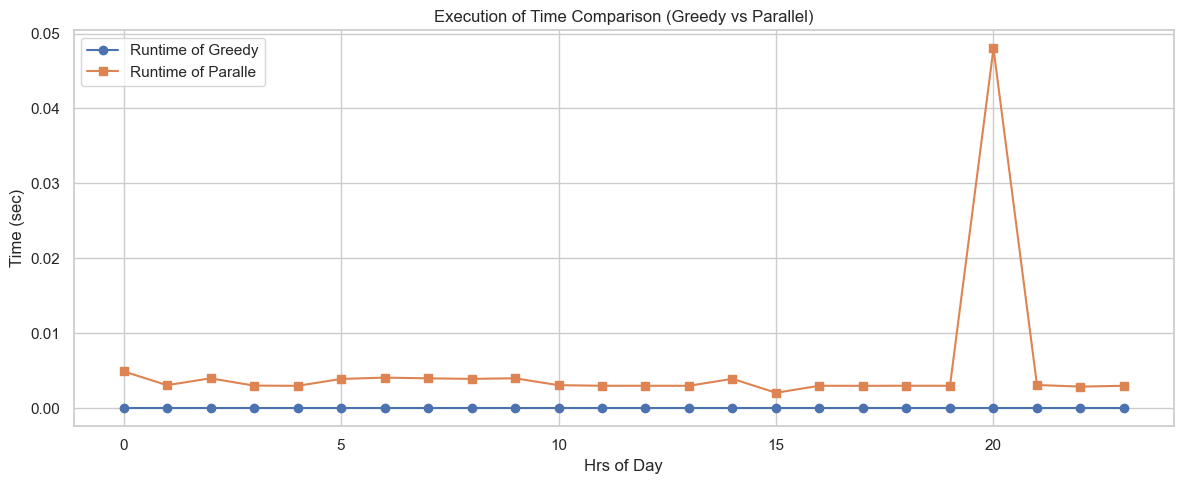


NODES:
Node ID: 1
  Base Demand     : 100 MW
  Max Capacity    : 200 MW
  Transmission Loss: 0.05
----------------------------------------
Node ID: 2
  Base Demand     : 120 MW
  Max Capacity    : 220 MW
  Transmission Loss: 0.04
----------------------------------------
Node ID: 3
  Base Demand     : 80 MW
  Max Capacity    : 180 MW
  Transmission Loss: 0.03
----------------------------------------
Node ID: 4
  Base Demand     : 90 MW
  Max Capacity    : 190 MW
  Transmission Loss: 0.06
----------------------------------------
Node ID: 5
  Base Demand     : 110 MW
  Max Capacity    : 210 MW
  Transmission Loss: 0.07
----------------------------------------
Node ID: 6
  Base Demand     : 95 MW
  Max Capacity    : 195 MW
  Transmission Loss: 0.05
----------------------------------------
Node ID: 7
  Base Demand     : 130 MW
  Max Capacity    : 230 MW
  Transmission Loss: 0.04
----------------------------------------
Node ID: 8
  Base Demand     : 75 MW
  Max Capacity    : 175 MW
  Trans

C:\Users\sanje\AppData\Local\Temp\ipykernel_14244\913353676.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=costs, ax=ax2, palette="Set2")


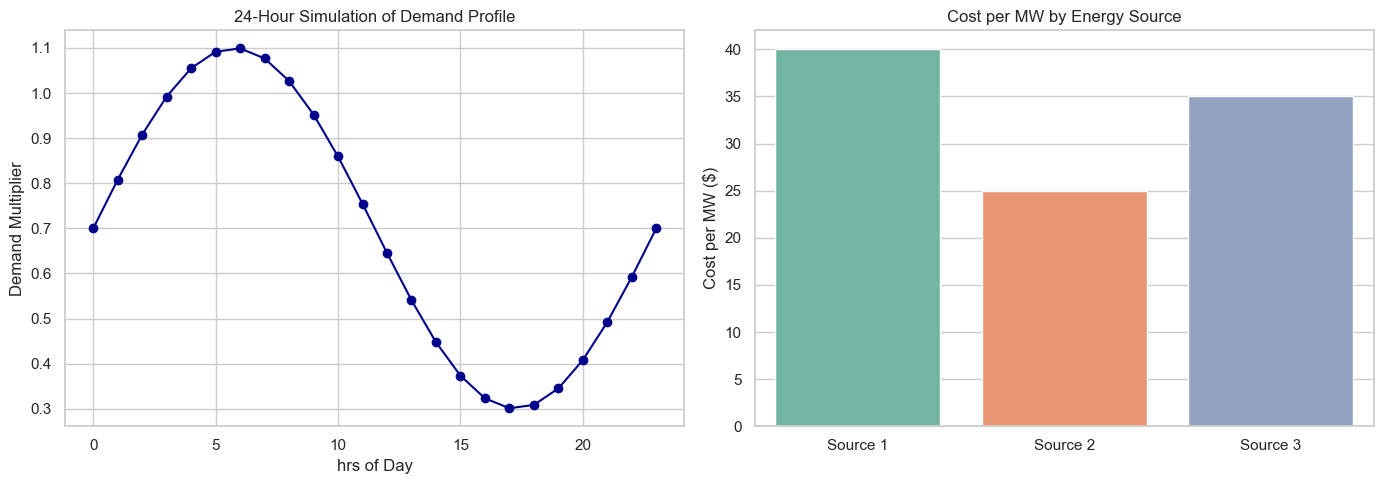

In [16]:

# Enable Seaborn styling
sns.set(style="whitegrid")

# Define the GridNode and EnergySource data structures
@dataclass
class GridNode:
    id: int
    base_demand: float
    max_capacity: float
    transmission_loss: float

@dataclass
class EnergySource:
    id: int
    max_supply: float
    cost_per_mw: float
    availability: float

# Define a static grid with 10 fixed nodes
NODES = [
    GridNode(id=1, base_demand=100, max_capacity=200, transmission_loss=0.05),
    GridNode(id=2, base_demand=120, max_capacity=220, transmission_loss=0.04),
    GridNode(id=3, base_demand=80,  max_capacity=180, transmission_loss=0.03),
    GridNode(id=4, base_demand=90,  max_capacity=190, transmission_loss=0.06),
    GridNode(id=5, base_demand=110, max_capacity=210, transmission_loss=0.07),
    GridNode(id=6, base_demand=95,  max_capacity=195, transmission_loss=0.05),
    GridNode(id=7, base_demand=130, max_capacity=230, transmission_loss=0.04),
    GridNode(id=8, base_demand=75,  max_capacity=175, transmission_loss=0.06),
    GridNode(id=9, base_demand=105, max_capacity=205, transmission_loss=0.05),
    GridNode(id=10, base_demand=115, max_capacity=215, transmission_loss=0.03),
]

# Define 3 fixed energy sources
SOURCES = [
    EnergySource(id=1, max_supply=400, cost_per_mw=40, availability=0.95),
    EnergySource(id=2, max_supply=300, cost_per_mw=25, availability=0.70),
    EnergySource(id=3, max_supply=200, cost_per_mw=35, availability=0.99),
]
# Define a fixed 24-hour sinusoidal demand multiplier
HOURLY_DEMAND_MULTIPLIER = 0.7 + 0.4 * np.sin(np.linspace(0, 2 * np.pi, 24))

# EDA function
def perform_eda(demand_multipliers, sources):
    print("\nPerforming Exploratory of Data Analysis")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(np.arange(24), demand_multipliers, marker='o', linestyle='-', color='darkblue')
    ax1.set_title('24-Hour Simulation of Demand Profile')
    ax1.set_xlabel('hrs of Day')
    ax1.set_ylabel('Demand Multiplier')
    ax1.grid(True)

    costs = [s.cost_per_mw for s in sources]
    labels = [f'Source {s.id}' for s in sources]
    sns.barplot(x=labels, y=costs, ax=ax2, palette="Set2")
    ax2.set_title('Cost per MW by Energy Source')
    ax2.set_ylabel('Cost per MW ($)') # mw vaneko Megawatt ho i.e.[1 Megawatt (MW) = 1,000,000 watts]

    plt.tight_layout()
    plt.show()

# Greedy allocation function
def greedy_allocation(nodes, sources, multiplier):
    total_cost = 0
    for node in nodes:
        demand = node.base_demand * multiplier
        for source in sorted(sources, key=lambda s: s.cost_per_mw):
            available = source.max_supply * source.availability
            supply = min(demand, available)
            cost = supply * source.cost_per_mw
            total_cost += cost
            demand -= supply
            if demand <= 0:
                break
    return total_cost

# Parallel dummy function (mock of genetic algorithm)
def parallel_allocation(nodes, sources, multiplier):
    def evaluate_solution(dummy):
        cost = 0
        for node in nodes:
            demand = node.base_demand * multiplier
            source = random.choice(sources)
            available = source.max_supply * source.availability
            supply = min(demand, available)
            cost += supply * source.cost_per_mw
        return cost

    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(evaluate_solution, range(100)))
    return min(results)

    # Measure execution times and compare
greedy_times = []
parallel_times = []
greedy_costs = []
parallel_costs = []

print("\nStarting of 24Hrs Simulation for Comparison")
for hour in range(24):
    multiplier = HOURLY_DEMAND_MULTIPLIER[hour]

    # Greedy execution
    start = time.time()
    greedy_cost = greedy_allocation(NODES, SOURCES, multiplier)
    greedy_duration = time.time() - start

    # Parallel execution
    start = time.time()
    parallel_cost = parallel_allocation(NODES, SOURCES, multiplier)
    parallel_duration = time.time() - start

    greedy_times.append(greedy_duration)
    parallel_times.append(parallel_duration)
    greedy_costs.append(greedy_cost)
    parallel_costs.append(parallel_cost)

    print(f"Hrs {hour:02d} | Greedy: ${greedy_cost:.2f} in {greedy_duration:.4f}s | "
          f"Parallel: ${parallel_cost:.2f} in {parallel_duration:.4f}s")

# Plot runtime comparison
plt.figure(figsize=(12, 5))
plt.plot(greedy_times, label='Runtime of Greedy', marker='o')
plt.plot(parallel_times, label='Runtime of Paralle', marker='s')
plt.title('Execution of Time Comparison (Greedy vs Parallel)')
plt.xlabel('Hrs of Day')
plt.ylabel('Time (sec)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Node ani Source of output nikaleko
print("\nNODES:")
for node in NODES:
    print(f"Node ID: {node.id}")
    print(f"  Base Demand     : {node.base_demand} MW")
    print(f"  Max Capacity    : {node.max_capacity} MW")
    print(f"  Transmission Loss: {node.transmission_loss}")
    print("-" * 40)

print("\nSOURCES:")
for source in SOURCES:
    print(f"Source ID: {source.id}")
    print(f"  Max Supply     : {source.max_supply} MW")
    print(f"  Cost per MW    : ${source.cost_per_mw}")
    print(f"  Availability   : {source.availability}")
    print("-" * 40)

# Run EDA
perform_eda(HOURLY_DEMAND_MULTIPLIER, SOURCES)


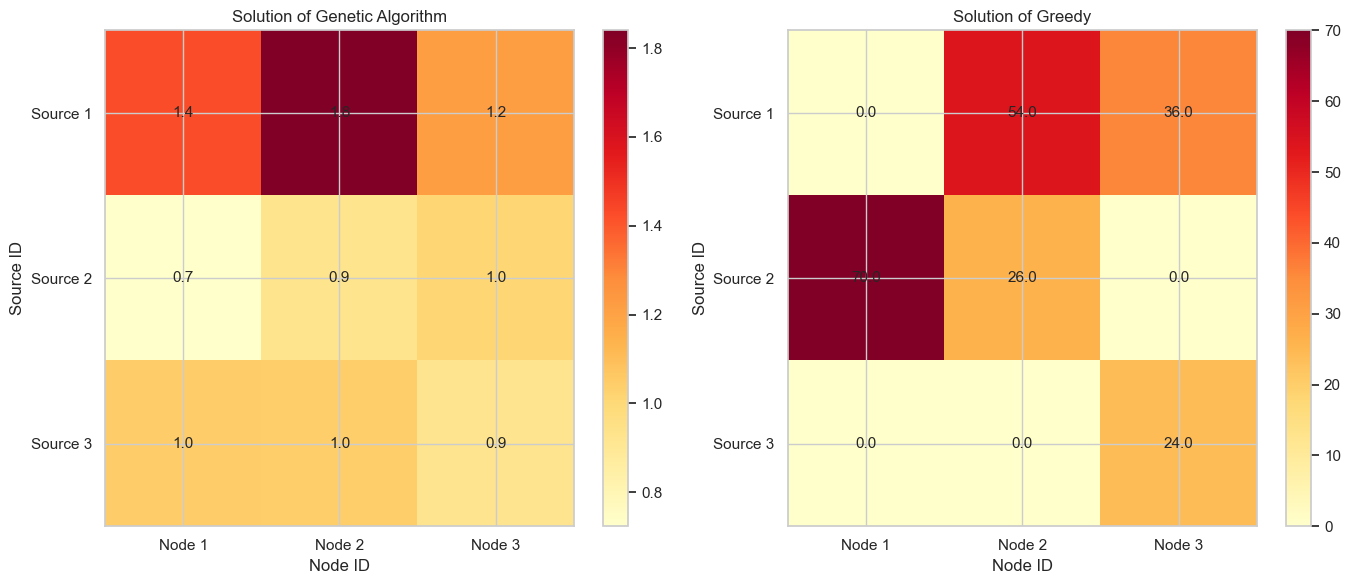

In [17]:
# Heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ga_allocation = best_solution.reshape(len(sources), len(nodes))
im1 = ax1.imshow(ga_allocation, cmap='YlOrRd', aspect='auto')
ax1.set_title('Solution of Genetic Algorithm')
ax1.set_xlabel('Node ID')
ax1.set_ylabel('Source ID')
ax1.set_xticks(range(len(nodes)))
ax1.set_yticks(range(len(sources)))
ax1.set_xticklabels([f'Node {i+1}' for i in range(len(nodes))])
ax1.set_yticklabels([f'Source {i+1}' for i in range(len(sources))])
for i in range(len(sources)):
    for j in range(len(nodes)):
        ax1.text(j, i, f'{ga_allocation[i, j]:.1f}', ha="center", va="center", fontsize=11)
plt.colorbar(im1, ax=ax1)

greedy_allocation = greedy_solution.reshape(len(sources), len(nodes))
im2 = ax2.imshow(greedy_allocation, cmap='YlOrRd', aspect='auto')
ax2.set_title('Solution of Greedy')
ax2.set_xlabel('Node ID')
ax2.set_ylabel('Source ID')
ax2.set_xticks(range(len(nodes)))
ax2.set_yticks(range(len(sources)))
ax2.set_xticklabels([f'Node {i+1}' for i in range(len(nodes))])
ax2.set_yticklabels([f'Source {i+1}' for i in range(len(sources))])
for i in range(len(sources)):
    for j in range(len(nodes)):
        ax2.text(j, i, f'{greedy_allocation[i, j]:.1f}', ha="center", va="center", fontsize=11)
plt.colorbar(im2, ax=ax2)
plt.tight_layout()
plt.show()
